# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a prospect will churn or not.


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Step 1: Load Data

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv")
      .drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1)  
                    # target variable for regressor, remove from classifier  
                    # drop other variables we will not need for this project
  )
cat_vars = ['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']
df[cat_vars] = df[cat_vars].astype(object)

print(df.shape)
print(df[cat_vars].dtypes)
df.head(3)

(10000, 11)
Geography         object
Gender            object
HasCrCard         object
IsActiveMember    object
NumOfProducts     object
dtype: object


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=cat_vars)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Geography', 'Gender', 'HasCrCard',
                                           'IsActiveMember',
                                           'NumOfProducts'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [63]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [131]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            param_grid = self.params[key]
            gs = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(8000, 10) (8000,) (2000, 10) (2000,)


## Handle Target Imbalance

In [12]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 10) (8000,) (2000, 10) (2000,)


Check Train Set Target distribution

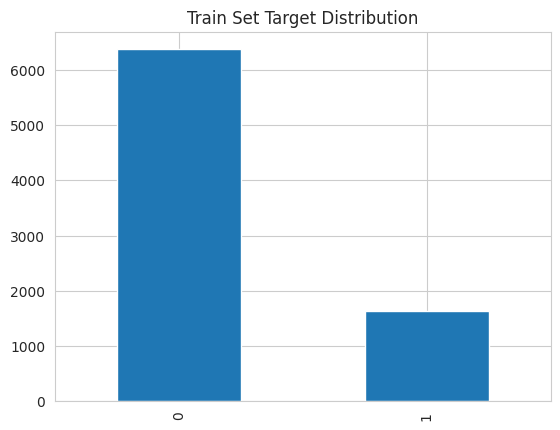

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [14]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12736, 10) (12736,) (2000, 10) (2000,)


Check Train Set Target distribution after resampling

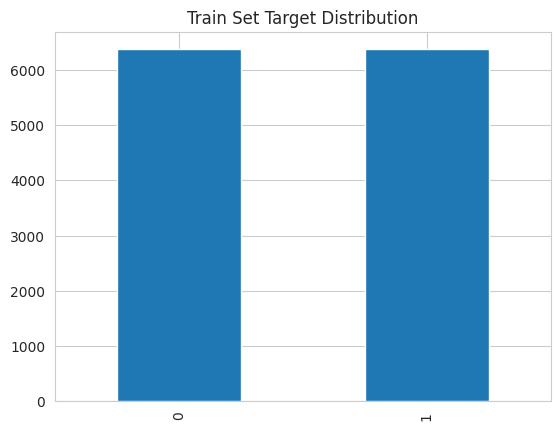

In [15]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [16]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [17]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.717425,0.814073,0.870487,0.05158
5,ExtraTreesClassifier,0.587127,0.798537,0.868814,0.107802
4,GradientBoostingClassifier,0.576138,0.791469,0.872057,0.110133
0,LogisticRegression,0.612245,0.77859,0.850078,0.085694
2,DecisionTreeClassifier,0.693093,0.76712,0.799686,0.040186
6,AdaBoostClassifier,0.675824,0.73713,0.765122,0.03148
1,XGBClassifier,0.359498,0.732124,0.856358,0.187887


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [125]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
}

# models_search = RandomForestClassifier(random_state=0)
# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {'RandomForestClassifier'{'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False]
    }
}
# params_search =  {'n_estimators': [10, 50, 100, 200],
#     'max_depth': [3, 5, 7, 9],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 4, 8],
#     'bootstrap': [True, False]
# }


clf = RandomForestClassifier()
params = clf.get_params()
available_params = params.keys()
print(available_params)

# models_search = {
#     "XGBClassifier":XGBClassifier(random_state=0),
# }
# # documentation to help on hyperparameter list: 
# # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# # We will not conduct an extensive search, since the focus
# # is on how to combine all knowledge in an applied project.
# # In a workplace project, you may spend more time in this step
# params_search = {
#     "XGBClassifier":{
#         'model__learning_rate': [1e-1,1e-2,1e-3], 
#         'model__max_depth': [3,10,None],
#     }
# }

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


Extensive GridSearch CV - Binary Classifier

In [132]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
# search = GridSearchCV(estimator = models_search, param_grid = params_search, cv = 3, verbose=2, n_jobs = 4)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5
           )


Running GridSearchCV for RandomForestClassifier 



KeyError: 'RandomForestClassifier'

Check results

In [115]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

AttributeError: 'GridSearchCV' object has no attribute 'score_summary'

Get best model name programmatically

In [55]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [40]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.001, 'model__max_depth': 3}

Define the best clf pipeline

In [41]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importance_type='gain',
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_delta_step=None,
                                                         max_depth=None

## Assess feature importance

In [42]:
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary
0,667,0,0,34,5,0.00,0,0,163830.64
1,427,1,1,42,1,75681.52,0,1,57098.00
2,535,2,0,29,2,112367.34,0,0,185630.76


* With the current model, we can assess with `.features_importances_`

* These are the 3 most important features in descending order. The model was trained on them: 
['Age', 'IsActiveMember', 'Gender']


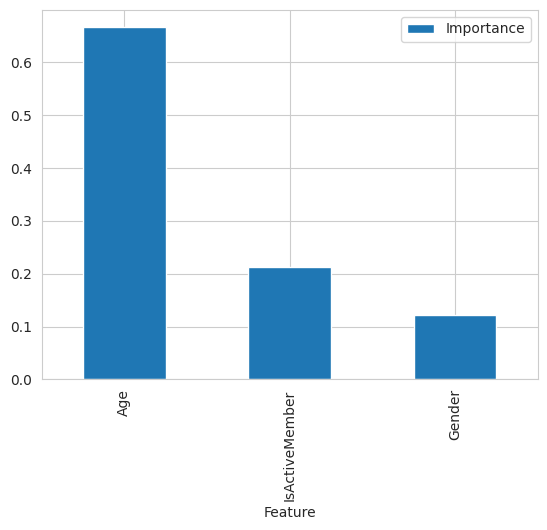

In [43]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

In [44]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [45]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            4310         1022
Prediction Churn               2058         5346


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.81      0.68      0.74      6368
       Churn       0.72      0.84      0.78      6368

    accuracy                           0.76     12736
   macro avg       0.77      0.76      0.76     12736
weighted avg       0.77      0.76      0.76     12736
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            1070          124
Prediction Churn                525          281


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.90      0.67      0.77      1595
       Churn       0.35      0.69      0.46       405

    accuracy                           0.68      

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
best_features

New Pipeline for DataCleaning And FeatureEngineering

In [ ]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Age', 'Gender', 'IsActiveMember'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [ ]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


We filter only the most important variables

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

## Handle Target Imbalance

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Train Set Target distribution

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Train Set Target distribution after SMOTE

In [ ]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [ ]:
models_search   # XGBClassifier

And the best parameters from the last GridCV search 

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [47]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]},  # the value should be in []
}
params_search


{'XGBClassifier': {'model__learning_rate': [0.01], 'model__max_depth': [3]}}

GridSearch CV

In [48]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove

Check results

In [49]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,XGBClassifier,0.359498,0.74437,0.875196,0.193824,0.01,3


Define the best clf pipeline

In [50]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importance_type='gain',
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_delta_step=None,
                                                         max_depth=None

## Assess feature importance

In [53]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


ValueError: All arrays must be of the same length

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---